## PYHRV Freq Getting Analysis

The HRV feature extraction functions of the pyHRV toolbox have been implemented and categorized into three levels, which are intended to facilitate the usage and increase the usability of the toolbox according to the needs of the user or programming background. This multilevel-architecture is illustrated in the Figure below.


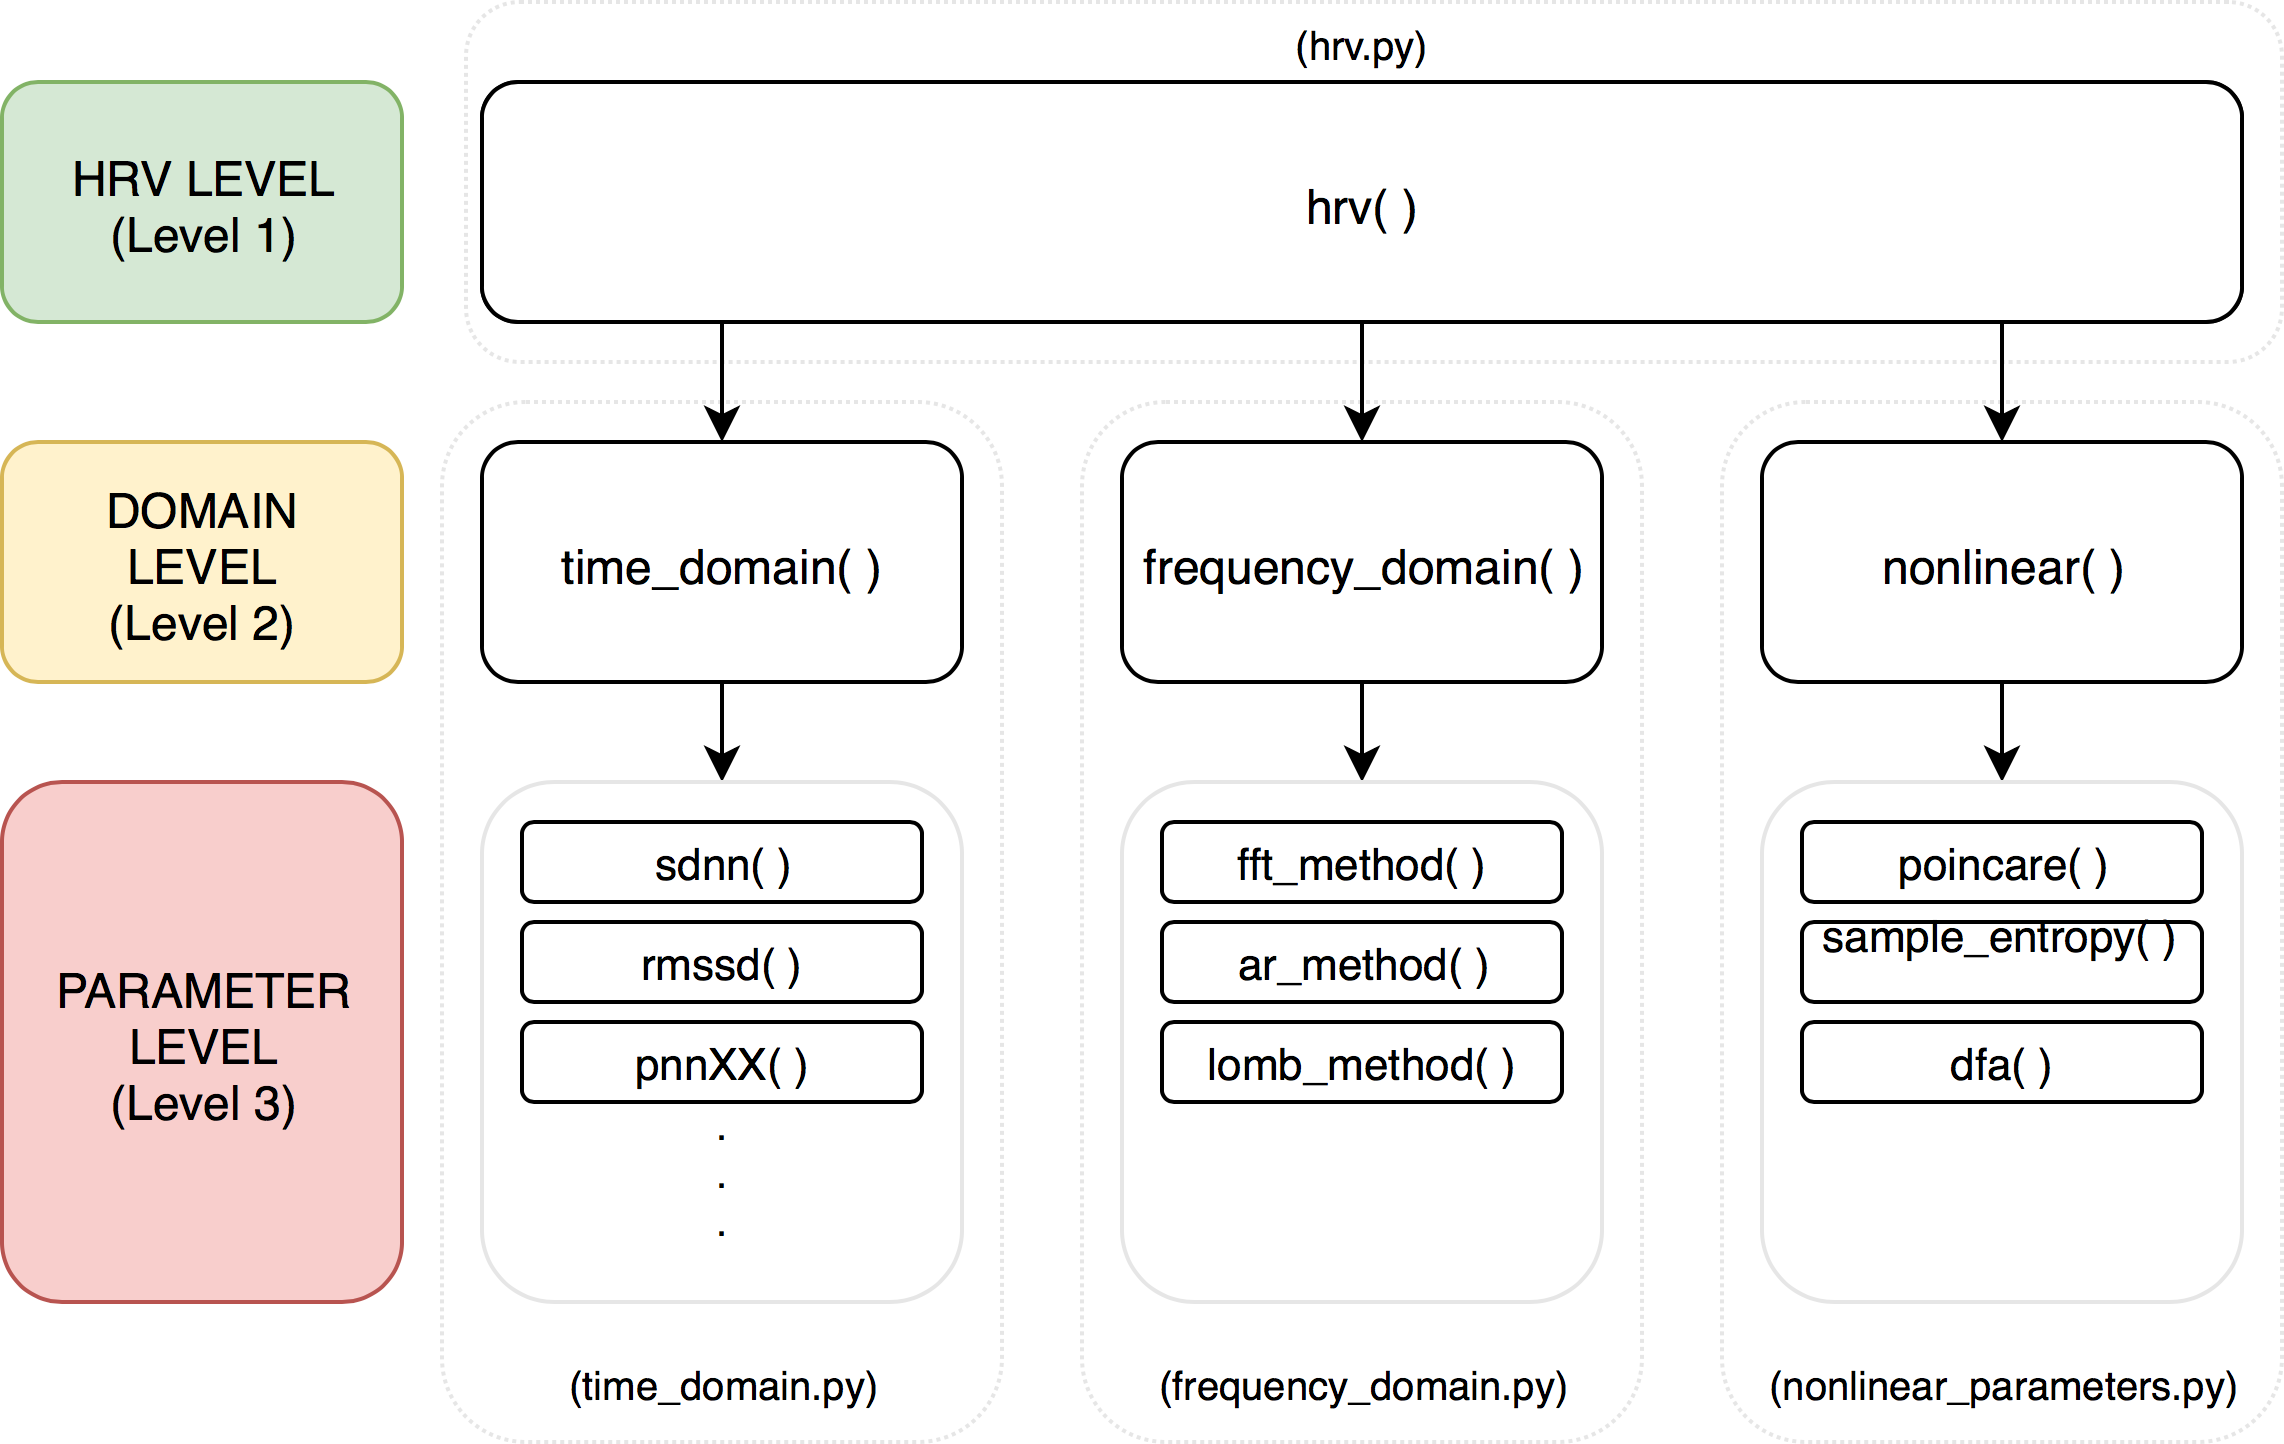

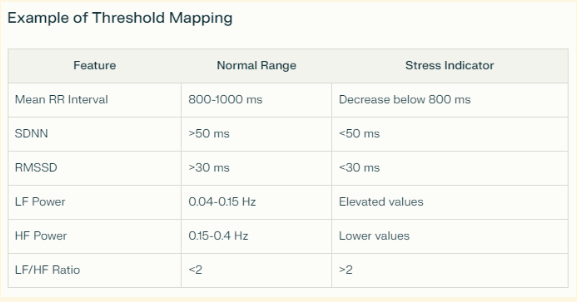

Normal ECG values for waves and intervals are as follows: RR interval: 0.6-1.2 seconds. P wave: 80 milliseconds. PR interval: 120-200 milliseconds

----
Ground Truth Subject 53 (35 Hz Sampling)

T1
- Welch : 0.931
- Lomb : 0.376

T2
- Welch : 0.241
- Lomb : 0.392

T3
- Welch : 0.304
- Lomb : 0.386

---

64 Hz Sampling

T1
- Welch : 0.893
- Lomb : 0.500

T2
- Welch : 0.220
- Lomb : 0.444

T3
- Welch : 0.078
- Lomb : 0.323

In [45]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from scipy import signal

In [46]:
## Ground Truth
ground_truth = pd.read_csv('../../Samples/Original/bvp_s53_T3.csv', header=None).values.flatten() # 64 Hz

In [47]:
# # Target sampling rate for upsampling
# upsample_rate = 100  # Hz
# fs = 64  # Hz

# # Calculate the number of samples after upsampling
# num_samples_upsampled = int(len(ground_truth) * (upsample_rate / 64))

# # Upsample the ground truth data
# upsampled_ground_truth = signal.resample(ground_truth, num_samples_upsampled)

# # Create a new DataFrame for the upsampled data
# # upsampled_ground_truth_df = pd.DataFrame(upsampled_ground_truth, columns=['BVP'])

# # Show the upsampled ground truth length
# print(f"Upsampled ground truth length: {len(upsampled_ground_truth)}")

In [48]:
## Downsampling the ground truth to match on 35.14 Hz

# Original ground truth sampling rate
original_rate = 64.0  # Hz

# Target sampling rate
target_rate = 35  # Hz

# Number sampling rate
fs = 35

# Calculate the number of samples after resampling
num_samples = int(len(ground_truth) * (target_rate / original_rate))

# Resample the ground truth data
downsampled_ground_truth = signal.resample(ground_truth, num_samples)

# Create a new DataFrame for the downsampled data
downsampled_ground_truth_df = pd.DataFrame(downsampled_ground_truth, columns=['BVP'])

## Show the downsampled ground truth length
print(f"Downsampled ground truth length: {len(downsampled_ground_truth)}")


Downsampled ground truth length: 6300


In [49]:
def preprocess_signal(rppg_signal, fs):
    # Narrower bandpass around expected heart rate frequencies (0.8-2.0 Hz)
    b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, rppg_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed = np.convolve(filtered, np.ones(window)/window, mode='same')
    
    return smoothed

In [50]:
# # ## Take the sample of the first 30 seconds with 35 frame rate of the ground truth
# interval_duration = 30  # seconds
# fs=35

# downsampled_ground_truth = downsampled_ground_truth[:6*interval_duration*fs]
# print(len(downsampled_ground_truth))

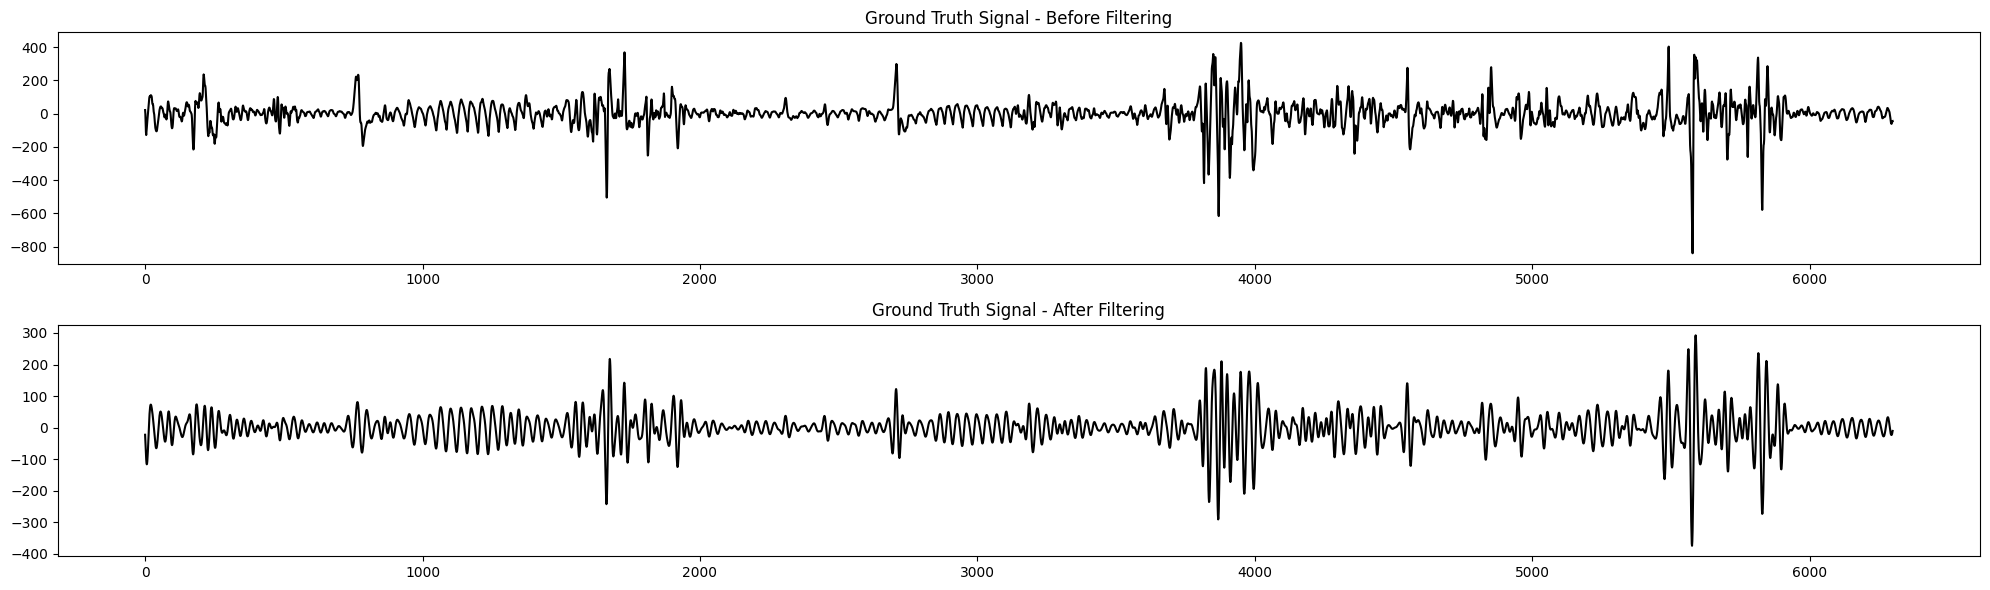

In [51]:
filtered_ground_truth = preprocess_signal(downsampled_ground_truth, fs=35)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(downsampled_ground_truth, color='black')
ax[0].set_title('Ground Truth Signal - Before Filtering')
ax[1].plot(filtered_ground_truth, color='black')
ax[1].set_title('Ground Truth Signal - After Filtering')
plt.tight_layout()
plt.show()

In [52]:
# Detect R-peaks in the filtered ground truth signal
rpeaks, _ = signal.find_peaks(filtered_ground_truth, distance=fs*0.6)  # Assuming minimum heart rate of 60 bpm

# Calculate RR intervals in milliseconds
rr_intervals = np.diff(rpeaks) / fs

# Print the RR intervals
print("RR Intervals:", len(rr_intervals))

RR Intervals: 195


c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\pyhrv\utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\pyhrv\time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")
c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\pyhrv\time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


SDNN: 1.9420274498351704
RMSSD: 2.8499264776192126
NN50: 1.64
pNN50: 0.845360824742268


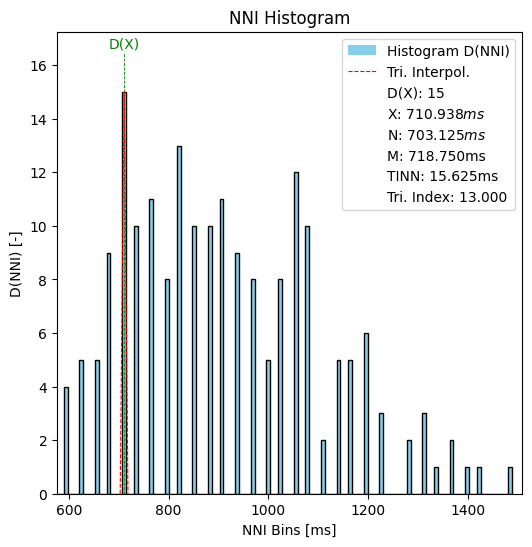

In [53]:
import pyhrv.time_domain as td

# Compute the time domain HRV features
time_domain_features = td.time_domain(nni=rr_intervals)

# Print the results, I guess in percent
print("SDNN:", time_domain_features['sdnn'] / 100)
print("RMSSD:", time_domain_features['rmssd'] / 100)
print("NN50:", time_domain_features['nn50'] / 100)
print("pNN50:", time_domain_features['pnn50'] / 100)

---
PYHRV

Length of NNI:  11


c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\pyhrv\tools.py:228: UserWarning: Interval limits out of boundaries. Interval set to: [0, 6.299]
  interval = pyhrv.utils.check_interval(interval, limits=[0, t[-1]], default=[0, 10])


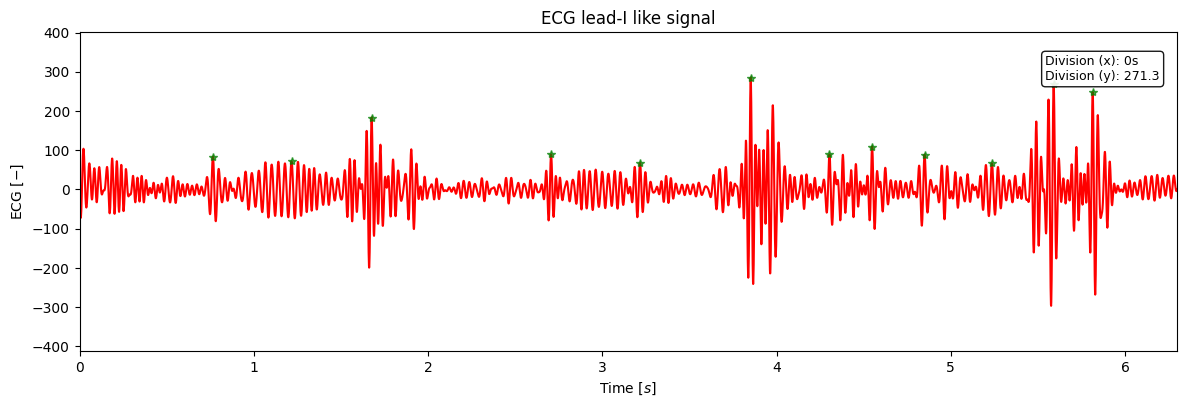

ReturnTuple(ecg_plot=<Figure size 1200x400 with 1 Axes>)

In [54]:
import biosppy
import numpy as np
import pyhrv.tools as tools
import pandas as pd


## Open files using pandas

signal, rpeaks = biosppy.signals.ecg.ecg(filtered_ground_truth, show=False)[1:3]

# Compute NNI
nni = tools.nn_intervals(rpeaks)

## Print length of NNI
print('Length of NNI: ', len(nni))

## Plot the signal
tools.plot_ecg(signal, interval=[0, 15])



In [55]:
def hrv_time_domain_analysis(nni):
    # Calculate the mean of NN intervals
    nni_mean = np.mean(nni)
    
    # Calculate the standard deviation of NN intervals (SDNN)
    sdnn = np.std(nni, ddof=1)
    
    # Calculate the root mean square of successive differences (RMSSD)
    diff_nni = np.diff(nni)
    rmssd = np.sqrt(np.mean(diff_nni ** 2))
    
    # Calculate NN50 and pNN50
    nn50 = np.sum(np.abs(diff_nni) > 50)
    pnn50 = (nn50 / len(diff_nni))
    
    return {
        'nni_mean': nni_mean,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'nn50': nn50,
        'pnn50': pnn50
    }

# Perform HRV time domain analysis
hrv_features = hrv_time_domain_analysis(nni)

# Print the results
print("NNI Mean:", hrv_features['nni_mean'])
print("SDNN:", hrv_features['sdnn'])
print("RMSSD:", hrv_features['rmssd'])
print("NN50:", hrv_features['nn50'])
print("pNN50:", hrv_features['pnn50'])

NNI Mean: 459.09090909090907
SDNN: 224.0421632396253
RMSSD: 267.5159808310524
NN50: 8
pNN50: 0.8


224.0421632396253
267.5159808310524
8


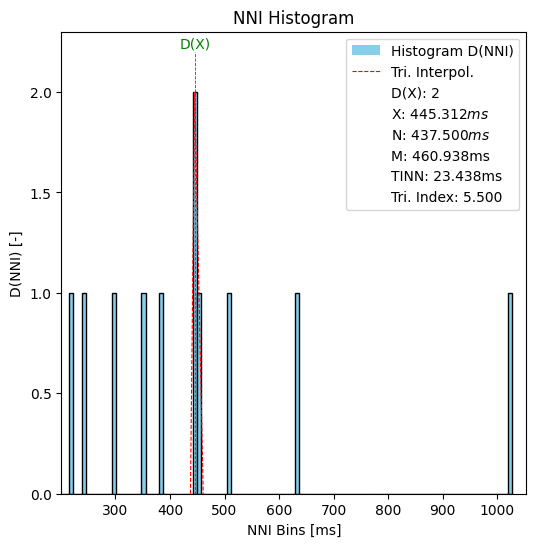

In [56]:
## Compute Time Domain
import pyhrv.time_domain as td

# Compute SDNN
results = td.time_domain(nni)

# Access time domain results value using the parameter keys 'sdnn', 'rmssd', 'nn50'
print(results['sdnn'])
print(results['rmssd'])
print(results['nn50'])


## Freq Domains

Use the welch_psd() function to compute the PSD from the NNI series using the Welch's method. This function will return the PSD plot and the computed frequency domain parameters from each frequency band.

The default frequency bands are specified as follows:

- VLF: 0.00Hz to 0.04Hz
- LF: 0.04Hz to 0.15Hz
- HF: 0.15Hz to 0.40Hz


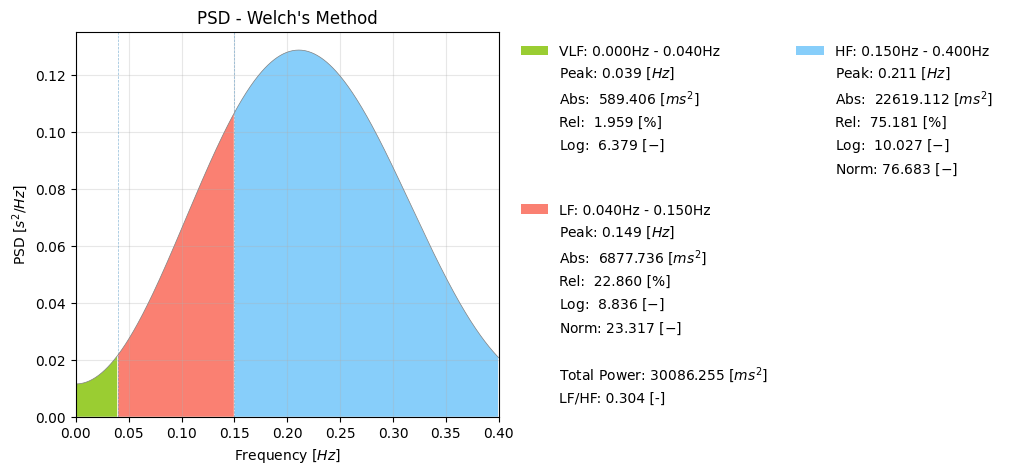

(0.0390625, 0.1494140625, 0.2109375)


In [57]:
import pyhrv.frequency_domain as fd
from scipy.interpolate import CubicSpline

# Compute the PSD and frequency domain parameters
time_points = np.cumsum(nni) / 1000  # Convert to seconds
cs = CubicSpline(time_points, nni)

# Create evenly sampled time points
even_time_points = np.linspace(time_points[0], time_points[-1], len(nni))
interpolated_rr = cs(even_time_points)

result = fd.welch_psd(nni=nni)

# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])


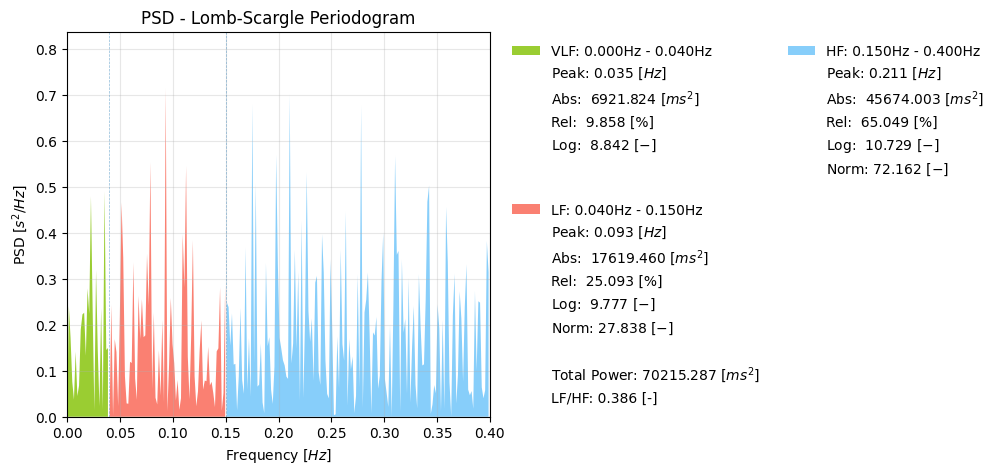

[0.         0.00160784 0.00321569 0.00482353 0.00643137 0.00803922
 0.00964706 0.0112549  0.01286275 0.01447059 0.01607843 0.01768627
 0.01929412 0.02090196 0.0225098  0.02411765 0.02572549 0.02733333
 0.02894118 0.03054902 0.03215686 0.03376471 0.03537255 0.03698039
 0.03858824 0.04019608 0.04180392 0.04341176 0.04501961 0.04662745
 0.04823529 0.04984314 0.05145098 0.05305882 0.05466667 0.05627451
 0.05788235 0.0594902  0.06109804 0.06270588 0.06431373 0.06592157
 0.06752941 0.06913725 0.0707451  0.07235294 0.07396078 0.07556863
 0.07717647 0.07878431 0.08039216 0.082      0.08360784 0.08521569
 0.08682353 0.08843137 0.09003922 0.09164706 0.0932549  0.09486275
 0.09647059 0.09807843 0.09968627 0.10129412 0.10290196 0.1045098
 0.10611765 0.10772549 0.10933333 0.11094118 0.11254902 0.11415686
 0.11576471 0.11737255 0.11898039 0.12058824 0.12219608 0.12380392
 0.12541176 0.12701961 0.12862745 0.13023529 0.13184314 0.13345098
 0.13505882 0.13666667 0.13827451 0.13988235 0.1414902  0.14309

In [58]:
import pyhrv.frequency_domain as fd

# Compute the PSD and frequency domain parameters
stuff, freq, powers = fd.lomb_psd(nni=nni, mode='devplot')

# Access the freq and powers
print(freq)
print(powers)

